In [1]:
from pathlib import Path

import mlflow
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from optuna.integration import MLflowCallback

from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from utils import log_result, calculate_metrics


In [2]:
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True)  # create experiments dir
mlflow.set_tracking_uri("file:///" + str(MODEL_REGISTRY.absolute()))

Podział danych

In [3]:
train = pd.read_csv("../data/modeling/train.csv")
test = pd.read_csv("../data/modeling/test.csv")

In [4]:
X_train = train.drop("cas_class", axis=1)
y_train = train["cas_class"]
X_test = test.drop("cas_class", axis=1)
y_test = test["cas_class"]

In [5]:
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name=["accuracy", "precision", "recall", "f1"])

C:\Users\Tuszyn\AppData\Local\Temp\ipykernel_4196\3644345758.py:1: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(


Wyszukiwanie hiperparametrów dla maszyn wektorów nośnych

In [14]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 0.0001, 0.1),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "dual": trial.suggest_categorical("dual", [False]),
        "penalty": trial.suggest_categorical("penalty", ["l1"])
    }

    model = LinearSVC(**params)

    scoring = ["accuracy", "precision", "recall", "f1"]

    preds = cross_validate(model, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

    accuracy = np.mean(preds["test_accuracy"])
    precision = np.mean(preds["test_precision"])
    recall = np.mean(preds["test_recall"])
    f1 = np.mean(preds["test_f1"])

    return accuracy, precision, recall, f1

In [15]:
study = optuna.create_study(study_name="support_vector_classifier",
                            directions=["maximize", "maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=100, callbacks=[mlflow_callback])

[I 2022-05-31 11:42:38,671] Trial 92 finished with values: [0.7640555906506632, 0.8230386717771919, 0.7615450095948864, 0.7910969697893417] and parameters: {'C': 0.40202876055721787, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1'}. 
[I 2022-05-31 11:42:40,708] Trial 93 finished with values: [0.7640646151069397, 0.8230525019674216, 0.7615450107780452, 0.7911033429851506] and parameters: {'C': 0.30421067375306216, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l2'}. 
[I 2022-05-31 11:42:42,621] Trial 94 finished with values: [0.7640555906506632, 0.8230495433002503, 0.7615296273460015, 0.7910936824189908] and parameters: {'C': 0.6124182299946374, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l2'}. 
[I 2022-05-31 11:42:49,405] Trial 95 finished with values: [0.7640916884757694, 0.8230719357298424, 0.7615757776421325, 0.7911289568482511] and parameters: {'C': 0.6675357020811684, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1'}. 
[I 2022-05-31 11:42:55

Zapis ostatecznego wyniku SVC


In [38]:
svc = LinearSVC(C=0.0036775852394361204, class_weight="balanced", dual=False, penalty="l1")
log_result(model=svc, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Wyszukwianie hiperparametrów dla regresji logistycznej

In [10]:
def objective(trial):
    params = {
        "C": trial.suggest_loguniform("C", 0.1, 10),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "max_iter": trial.suggest_categorical("max_iter", [500])
    }

    model = LogisticRegression(**params)

    scoring = ["accuracy", "precision", "recall", "f1"]

    preds = cross_validate(model, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

    accuracy = np.mean(preds["test_accuracy"])
    precision = np.mean(preds["test_precision"])
    recall = np.mean(preds["test_recall"])
    f1 = np.mean(preds["test_f1"])

    return accuracy, precision, recall, f1


In [11]:
study = optuna.create_study(study_name="logistic_regression",
                            directions=["maximize", "maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=20, callbacks=[mlflow_callback])

[I 2022-05-31 11:21:34,961] A new study created in memory with name: logistic_regression
[I 2022-05-31 11:21:38,228] Trial 0 finished with values: [0.7640736395632163, 0.8232505310795475, 0.7612834924333025, 0.7910523205943465] and parameters: {'C': 4.127485834816929, 'class_weight': 'balanced', 'max_iter': 500}. 
[I 2022-05-31 11:21:40,722] Trial 1 finished with values: [0.7640375417381103, 0.8231959627757112, 0.7612834924333025, 0.7910270764201621] and parameters: {'C': 9.035317495964168, 'class_weight': 'balanced', 'max_iter': 500}. 
[I 2022-05-31 11:21:42,449] Trial 2 finished with values: [0.7640465661943867, 0.823209507391752, 0.7612834924333025, 0.7910333391047828] and parameters: {'C': 0.2758855819905255, 'class_weight': 'balanced', 'max_iter': 500}. 
[I 2022-05-31 11:21:44,069] Trial 3 finished with values: [0.7640465661943867, 0.8231989133138761, 0.7612988746821873, 0.7910366775184539] and parameters: {'C': 0.14006943293003563, 'class_weight': 'balanced', 'max_iter': 500}. 
[

Zapis ostatecznego wyniku regresji logistycznej

In [ ]:
lr = LogisticRegression(C=9.58649376280703, class_weight="balanced", max_iter=500)
log_result(model=lr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


Wyszukiwanie hiperparametrów drzewo decyzyjne

In [83]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 15, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 40),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
    }

    model = DecisionTreeClassifier(**params)

    scoring = ["accuracy", "precision", "recall", "f1"]

    preds = cross_validate(model, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

    accuracy = np.mean(preds["test_accuracy"])
    precision = np.mean(preds["test_precision"])
    recall = np.mean(preds["test_recall"])
    f1 = np.mean(preds["test_f1"])

    return accuracy, precision, recall, f1

In [84]:
study = optuna.create_study(study_name="decision_tree",
                            directions=["maximize", "maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=100, callbacks=[mlflow_callback])

[I 2022-05-30 22:17:49,184] A new study created in memory with name: decision_tree
[I 2022-05-30 22:17:53,309] Trial 0 finished with values: [0.8379929609241044, 0.8664138853143701, 0.8558132240010412, 0.8610735043123647] and parameters: {'max_depth': 47, 'min_samples_leaf': 3, 'class_weight': 'balanced', 'criterion': 'gini'}. 
[I 2022-05-30 22:17:55,657] Trial 1 finished with values: [0.8463135096110459, 0.8880286157415048, 0.8445219268041602, 0.8657194570056808] and parameters: {'max_depth': 15, 'min_samples_leaf': 13, 'class_weight': 'balanced', 'criterion': 'gini'}. 
[I 2022-05-30 22:17:57,140] Trial 2 finished with values: [0.846512047649129, 0.8915249644477559, 0.8406607622495947, 0.8653344094614086] and parameters: {'max_depth': 16, 'min_samples_leaf': 20, 'class_weight': 'balanced', 'criterion': 'gini'}. 
[I 2022-05-30 22:17:59,144] Trial 3 finished with values: [0.8481003519537949, 0.8872340326220195, 0.848983074793227, 0.8676797324217764] and parameters: {'max_depth': 37, 'mi

Zapis ostatecznego wyniku drzewa decyzyjnego

In [9]:
dt = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", max_depth=21, min_samples_leaf=38)
log_result(model=dt, estimator_name="DecisionTreeClassifier", X_train=X_train, y_train=y_train, X_test=X_test,
           y_test=y_test)

Exception: Run with UUID 22e9bcab094b4f2884adc218e94efdc9 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

Wyszukiwanie hiperparametrów lasu losowego

In [17]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 30, 60),
        #"max_depth": trial.suggest_categorical("max_depth", [None]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt"]),
        "n_estimators": trial.suggest_int("n_estimators", 250, 1000)
    }

    model = RandomForestClassifier(**params)

    scoring = ["accuracy", "precision", "recall", "f1"]

    preds = cross_validate(model, X_train, y_train, cv=5, n_jobs=-2, scoring=scoring)

    accuracy = np.mean(preds["test_accuracy"])
    precision = np.mean(preds["test_precision"])
    recall = np.mean(preds["test_recall"])
    f1 = np.mean(preds["test_f1"])

    return accuracy, precision, recall, f1

In [ ]:
study = optuna.create_study(study_name="random_forest", directions=["maximize", "maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=10, callbacks=[mlflow_callback])

[I 2022-05-31 10:54:40,987] A new study created in memory with name: random_forest
[I 2022-05-31 10:56:18,639] Trial 0 finished with values: [0.8754534789278946, 0.8934953523811018, 0.8943020179449472, 0.8938958740893144] and parameters: {'max_depth': 51, 'min_samples_split': 8, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 821}. 
[I 2022-05-31 11:01:57,781] Trial 1 finished with values: [0.8697229491923112, 0.8968365132649458, 0.8790573384951716, 0.8878540178450292] and parameters: {'max_depth': 53, 'min_samples_split': 29, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'n_estimators': 710}. 
[I 2022-05-31 11:03:47,059] Trial 2 finished with values: [0.8732605360527028, 0.8965590105190341, 0.8862104782185118, 0.8913525787491737] and parameters: {'max_depth': 33, 'min_samples_split': 17, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 996}. 


Zapis ostatecznego wyniku lasu losowego

In [6]:
rf = RandomForestClassifier(criterion="entropy", max_depth=42, min_samples_split=6, n_estimators=551,
                            max_features="sqrt", class_weight="balanced", n_jobs=-1)
log_result(model=rf, estimator_name="RandomForestClassifier", X_train=X_train, y_train=y_train, X_test=X_test,
           y_test=y_test)

Wyszukwianie hiperparametrów dla XGBoost

In [9]:
def objective(trial):
    params = {
        "tree_method": "hist",
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.15),
        "min_child_weight": trial.suggest_int("min_child_weight", 0.1, 10),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 7),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.6),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.25, 0.85),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.4, 3.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 3.0),
        "gamma": trial.suggest_float("gamma", 0.1, 0.5),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.704, 1),
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
        "objective": "binary:logistic"
    }

    model = xgb.XGBClassifier(**params)

    scoring = ["accuracy", "precision", "recall", "f1"]

    preds = cross_validate(model, X_train, y_train, cv=5, n_jobs=-2, scoring=scoring)

    accuracy = np.mean(preds["test_accuracy"])
    precision = np.mean(preds["test_precision"])
    recall = np.mean(preds["test_recall"])
    f1 = np.mean(preds["test_f1"])

    return accuracy, precision, recall, f1

In [10]:
study = optuna.create_study(study_name="XGBoost", directions=["maximize", "maximize", "maximize", "maximize"])
study.optimize(objective, n_trials=100, callbacks=[mlflow_callback])

[I 2022-05-31 13:56:01,717] A new study created in memory with name: XGBoost
C:\Users\Tuszyn\.virtualenvs\JT_praca_magisterska\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  warnings.warn(
[I 2022-05-31 13:56:16,884] Trial 0 finished with values: [0.86807147369371, 0.8969961077170442, 0.8756729917276724, 0.8862032195841776] and parameters: {'max_depth': 13, 'learning_rate': 0.11615520591716848, 'min_child_weight': 1, 'max_delta_step': 1, 'subsample': 0.9018574998386311, 'colsample_bytree': 0.15843730447771195, 'colsample_bylevel': 0.36872742422719335, 'reg_lambda': 1.9977820656346417, 'reg_alpha': 0.46343199831319737, 'gamma': 0.21011901004779127, 'scale_pos_weight': 0.7116917684127338, 'n_estimators': 955}. 
C:\Users\Tuszyn\.virtualenvs\JT_praca_magisterska\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is spec

Zapis ostatecznego wyniku XGBoost

In [7]:
xgboost = xgb.XGBClassifier(colsample_bylevel=0.6783261477402747, colsample_bytree=0.23127225599162296,
                            gamma=0.4906870500968865, learning_rate=0.0675784773135259,
                            max_delta_step=5,
                            max_depth=22,
                            min_child_weight=1,
                            n_estimators=1475,
                            reg_alpha=0.12263684424466229,
                            reg_lambda=1.9559489540115411,
                            scale_pos_weight=0.9676022078596858,
                            subsample=0.976706655475712)
log_result(model=xgboost, estimator_name="XGBClassifier", X_train=X_train, y_train=y_train,
           X_test=X_test,
           y_test=y_test)

In [14]:
svc = LinearSVC(C=0.0036775852394361204, class_weight="balanced", dual=False, penalty="l1")
svc = CalibratedClassifierCV(svc)
rf = RandomForestClassifier(criterion="entropy", max_depth=42, min_samples_split=6, n_estimators=551,
                            max_features="sqrt", class_weight="balanced", n_jobs=-2)
dt = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", max_depth=21, min_samples_leaf=38)
lr = LogisticRegression(C=9.58649376280703, class_weight="balanced", max_iter=500)
xgboost = xgb.XGBClassifier(colsample_bylevel=0.6783261477402747, colsample_bytree=0.23127225599162296,
                            gamma=0.4906870500968865, learning_rate=0.0675784773135259,
                            max_delta_step=5,
                            max_depth=22,
                            min_child_weight=1,
                            n_estimators=1475,
                            reg_alpha=0.12263684424466229,
                            reg_lambda=1.9559489540115411,
                            scale_pos_weight=0.9676022078596858,
                            subsample=0.976706655475712)

In [15]:
voting_class = VotingClassifier(estimators=[("lr", lr), ("svc", svc), ("dt", dt), ("rf", rf), ("xgboost", xgboost)],
                                voting="soft", n_jobs=-2)

log_result(model=voting_class, estimator_name="VotingClassifier", X_train=X_train, y_train=y_train,
           X_test=X_test,
           y_test=y_test)

In [16]:
stacking_class = StackingClassifier(estimators=[("svc", svc), ("dt", dt), ("rf", rf), ("xgboost", xgboost)],
                                    final_estimator=lr, n_jobs=-2)
log_result(model=stacking_class, estimator_name="StackingClassifier", X_train=X_train, y_train=y_train,
           X_test=X_test,
           y_test=y_test)

Feature Importance

In [17]:
xgboost = xgb.XGBClassifier(colsample_bylevel=0.6783261477402747, colsample_bytree=0.23127225599162296,
                            gamma=0.4906870500968865, learning_rate=0.0675784773135259,
                            max_delta_step=5,
                            max_depth=22,
                            min_child_weight=1,
                            n_estimators=1475,
                            reg_alpha=0.12263684424466229,
                            reg_lambda=1.9559489540115411,
                            scale_pos_weight=0.9676022078596858,
                            subsample=0.976706655475712)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.6783261477402747, colsample_bynode=1,
              colsample_bytree=0.23127225599162296, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.4906870500968865, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0675784773135259, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=5, max_depth=22, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1475, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.12263684424466229,
              reg_lambda=1.9559489540115411, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

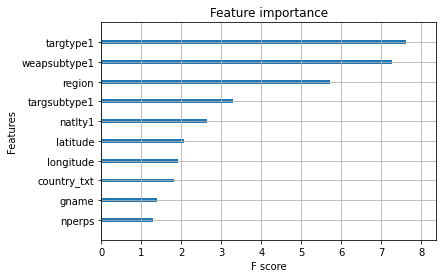

In [52]:
xgb.plot_importance(xgboost, max_num_features=10, importance_type="gain", show_values=False)